In [1]:
!hostname
!pwd

freeman-titanxp-5.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src


In [2]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np

from functools import partial

import gymnax
from mdps.wrappers import FlattenObservationWrapper, LogWrapper
from agents.basic import BasicAgent
from agents.linear_transformer import LinearTransformerAgent
from jax.random import split

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ppo_general import make_train

from mdps.gridworld import GridEnv
from mdps.discrete_smdp import DiscreteInit, DiscreteTransition, DiscreteObs, DiscreteReward
from mdps.continuous_smdp import ContinuousInit, ContinuousMatrixTransition, ContinuousMatrixObs, ContinuousReward
import mdps.discrete_smdp
from mdps.syntheticmdp import SyntheticMDP
from mdps.wrappers_mine import TimeLimit, RandomlyProjectObservation, NoReward


import networkx as nx
import matplotlib.pyplot as plt

from train import *

In [4]:
rng = jax.random.PRNGKey(0)

2023-11-15 11:08:22.523642: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [14]:
# env = create_env("env=dsmdp;n_states=64;n_acts=4;d_obs=64;rpo=64;tl=128")
env = create_env("env=gridenv;grid_len=8;fobs=T;rpo=64;tl=128")
env = create_env("env=mountaincar;fobs=T;rpo=64;tl=128")

o, _ = env.reset(rng, env.sample_params(rng))
print(o.shape, o)

agent = create_agent(env, 'linear_transformer', 128)

(64,) [-0.31825107 -0.23713031 -0.3608632  -0.59500897 -0.19427608 -0.14651963
  0.31730455  0.01528475 -0.71801513 -0.6657745   0.08559568  0.14281934
 -0.08322624  0.19306396  0.24626562 -0.45068195 -0.6832889  -0.60851985
 -0.3240075   0.970369   -0.2541314  -0.4078609   0.46856126  0.22858086
 -0.2207622  -0.5627024   0.5773953   0.3105703  -0.7128416  -0.97835517
 -0.24956867  0.35294124 -0.08393911 -0.73324186 -0.08602918 -0.1645603
 -0.8291145  -0.5333776   0.3968841  -0.07072891  0.42040822  0.37988636
  0.2153255   0.15848339  0.0505711  -0.5890802  -0.5760883  -0.31069067
  0.7340161  -0.634227    0.24048194  0.11125246  0.93137574  1.0255492
 -0.05471762 -0.25467765  0.24715674 -0.7197104   0.9379568   0.0049925
  0.24148472  0.3626793  -0.0529774   0.53118795]


In [27]:
with open('./data/rpo64.pkl', 'rb') as f:
    agent_params = pickle.load(f)
agent_params = jax.tree_map(lambda x: x[:4], agent_params)
agent_params_init = jax.tree_map(lambda x: jnp.zeros_like(x), agent_params)
print(jax.tree_map(lambda x: x.shape, agent_params))

{'params': {'actor': {'bias': (4, 4), 'kernel': (4, 128, 4)}, 'blocks_0': {'ln1': {'bias': (4, 128), 'scale': (4, 128)}, 'ln2': {'bias': (4, 128), 'scale': (4, 128)}, 'mha': {'dense1': {'bias': (4, 384), 'kernel': (4, 128, 384)}, 'dense2': {'bias': (4, 128), 'kernel': (4, 128, 128)}}, 'mlp': {'dense1': {'bias': (4, 512), 'kernel': (4, 128, 512)}, 'dense2': {'bias': (4, 128), 'kernel': (4, 512, 128)}}}, 'critic': {'bias': (4, 1), 'kernel': (4, 128, 1)}, 'embed_action': {'embedding': (4, 4, 128)}, 'embed_obs': {'bias': (4, 128), 'kernel': (4, 64, 128)}, 'embed_reward': {'bias': (4, 128), 'kernel': (4, 1, 128)}, 'embed_time': {'embedding': (4, 128, 128)}, 'ln': {'bias': (4, 128), 'scale': (4, 128)}}}


In [28]:
args = parser.parse_args(''.split())
config = vars(args)
config = {k.upper(): v for k, v in config.items()}
config = {k.replace('N_', 'NUM_'): v for k, v in config.items()}
config['ANNEAL_LR'] = False


In [29]:
rng = jax.random.PRNGKey(0)
rews = eval_agent(rng, config, env, agent, agent_params, 4)
rews_init = eval_agent(rng, config, env, agent, agent_params_init, 4)

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

ScopeParamShapeError: Initializer expected to generate shape (4, 128) but got shape (3, 128) instead for parameter "embedding" in "/embed_action". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [24]:
rews.shape, rews_init.shape

((4, 122, 128), (4, 122, 128))

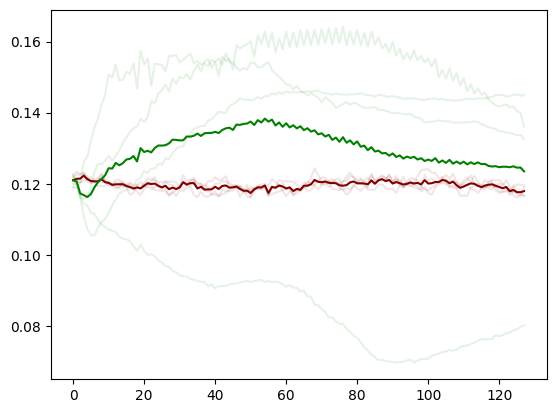

In [25]:
plt.plot(rews_init.mean(axis=1).T, c=[.5, 0, 0, .1])
plt.plot(rews_init.mean(axis=1).mean(axis=0), c=[.5, 0, 0, 1.])
plt.plot(rews.mean(axis=1).T, c=[0, .5, 0, .1])
plt.plot(rews.mean(axis=1).mean(axis=0), c=[0, .5, 0, 1.])
plt.show()

In [68]:
env = create_env('env=gridenv;grid_len=8;tl=128')
rng = jax.random.PRNGKey(0)

rews = []

for i in tqdm(range(100)):
    rng, _rng = split(rng)
    env_params = jax.vmap(env.sample_params)(split(_rng, 128))
    
    rng, _rng = split(rng)
    obs, env_state = jax.vmap(env.reset)(split(_rng, 128), env_params)
    for j in range(128):
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (128,), 0, 4)
        rng, _rng = split(rng)
        obs, state, rew, done, info = jax.vmap(env.step)(split(_rng, 128), env_state, act, env_params)
        rews.append(rew)


  0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
rews = jnp.concatenate(rews)

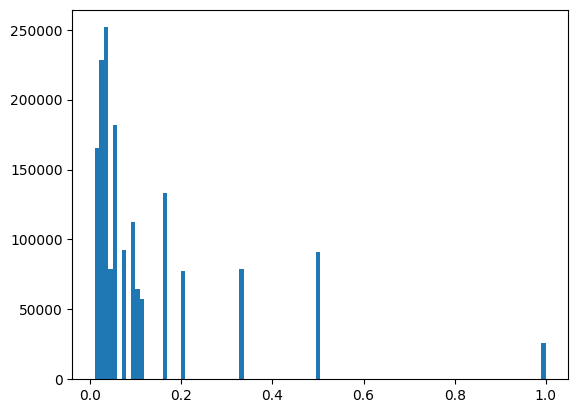

In [87]:
plt.hist(np.asarray(rews), bins=100);

In [81]:
jnp.mean(rews)


Array(0.11993616, dtype=float32)

array([0.05263158, 0.5       , 0.1666667 , ..., 0.02631579, 0.03703704,
       0.04761906], dtype=float32)

In [ ]:
def pvmap(fun, in_axes=None, out_axes=None):
    fun = jax.vmap(fun, in_axes=in_axes, out_axes=out_axes)

In [185]:
n_gpus = len(jax.devices())
n_gpus

6

In [1]:
'hello'

'hello'

In [4]:
from train import *

In [5]:
env = create_env("env=dsmdp;n_states=64;d_obs=64;rpo=Y;tl=4")

In [6]:
env.observation_space(None).high

TypeError: 'NoneType' object is not subscriptable

In [20]:
import os
import pickle
import glob

In [21]:
file2agent_params = {}
for file in glob.glob('./data/agent_*'):
    with open(file, 'rb') as f:
        agent_params = pickle.load(f)
    file2agent_params[file] = agent_params
agent_params_init = jax.tree_map(lambda x: jnp.zeros_like(x), agent_params)
file2agent_params['init'] = agent_params_init

In [22]:
from mdps.wrappers_mine import RewardTransform

In [23]:
# env = create_env("env=dsmdp;n_states=64;d_obs=64;rpo=F;tl=128")
env = create_env("env=gridenv;grid_len=8;fobs=T;rpo=64;tl=128")
# env = RewardTransform(env, lambda x: x/.12*.5)
agent = create_agent(env, 'linear_transformer', 128)

In [24]:
args = parser.parse_args(''.split())
config = vars(args)
config = {k.upper(): v for k, v in config.items()}
config = {k.replace('N_', 'NUM_'): v for k, v in config.items()}
config['ANNEAL_LR'] = False

In [26]:
file2rews = {}
for file, agent_params in file2agent_params.items():
    rng = jax.random.PRNGKey(0)
    rews = eval_agent(rng, config, env, agent, agent_params, 8)
    file2rews[file] = rews

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

In [27]:
file2rews['init'].shape

(8, 122, 128)

In [37]:
rews = file2rews['./data/agent_1.pkl']
rews.shape


(8, 122, 128)

In [50]:
rews[:, :, -1].std(axis=0).mean()

Array(0.06155339, dtype=float32)

In [51]:
rews[:, :, -1].std(axis=1).mean()

Array(0.01914198, dtype=float32)

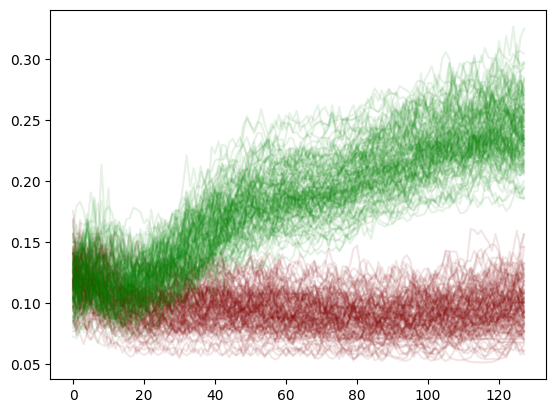

In [53]:
plt.plot(rews[0, :, :].T, c=[.5, 0, 0, 0.1]);
plt.plot(rews[1, :, :].T, c=[0, .5, 0, 0.1]);

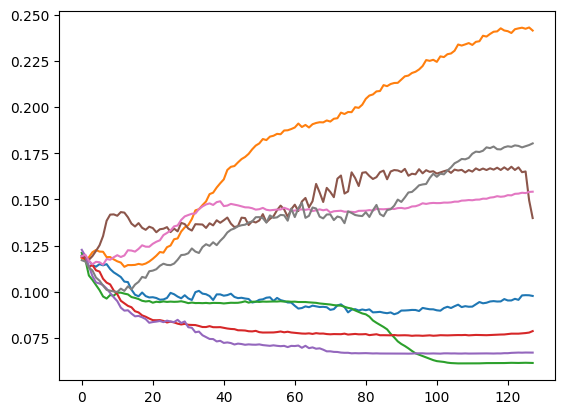

In [33]:
plt.plot(rews.mean(axis=1).T);

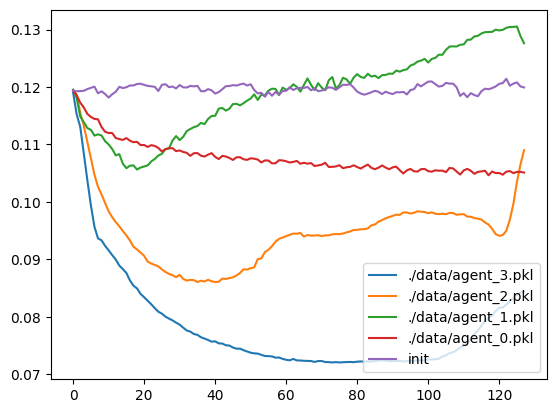

In [28]:
for file, rews in file2rews.items():
    plt.plot(rews.mean(axis=(0, 1)), label=file)
plt.legend()

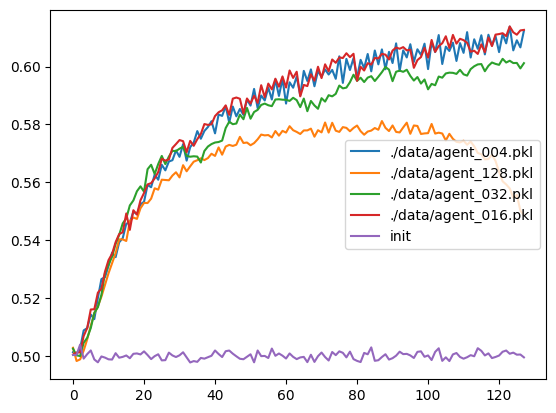

In [32]:
for file, rews in file2rews.items():
    plt.plot(rews.mean(axis=(0, 1)), label=file)
plt.legend()

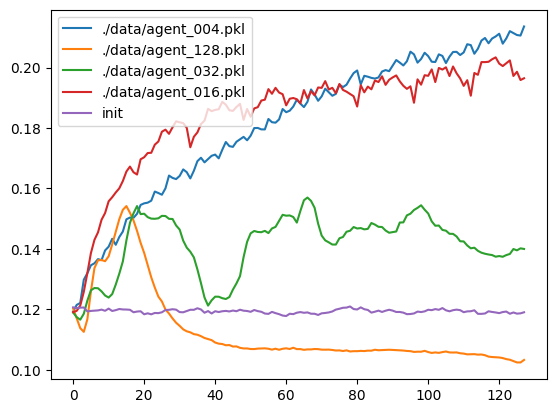

In [22]:
for file, rews in file2rews.items():
    plt.plot(rews.mean(axis=(0, 1)), label=file)
plt.legend()


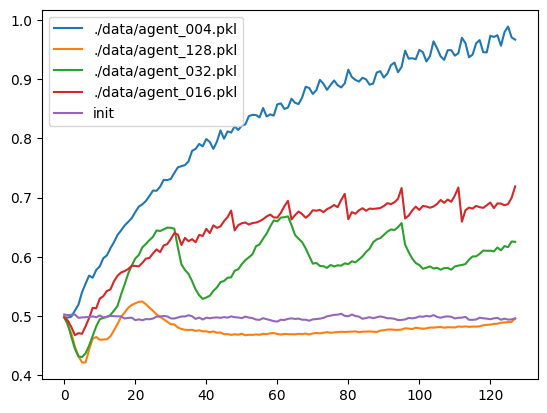

In [88]:
for file, rews in file2rews.items():
    plt.plot(rews.mean(axis=(0, 1)), label=file)
plt.legend()


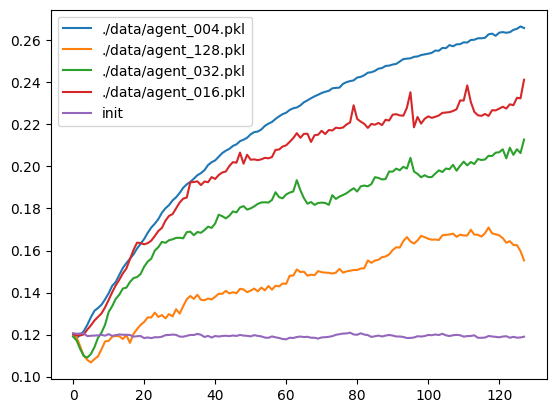

In [14]:

for file, rews in file2rews.items():
    plt.plot(rews.mean(axis=(0, 1)), label=file)
plt.legend()


In [59]:
from mdps.mountain_car import MountainCar
env = MountainCar()
env.sample_params = lambda rng: env.default_params


In [60]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
env_params = env.sample_params(_rng)

rews = []
rng, _rng = split(rng)
obs, state = env.reset(_rng, env_params)

for i in range(10000):
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (), 0, 3)
    rng, _rng = split(rng)
    obs, state, rew, done, info = env.step(_rng, state, 0, env_params)
    rews.append(rew)
rews = jnp.stack(rews)


In [61]:
rews = np.array(rews)



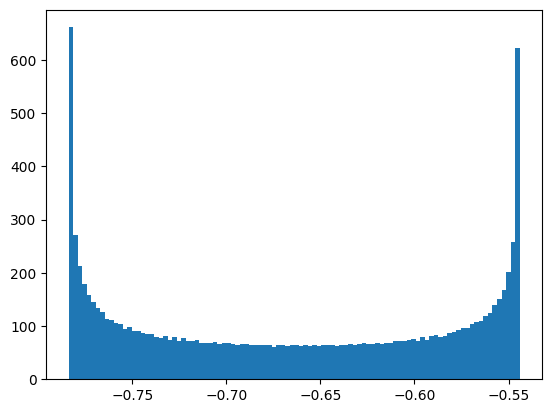

In [62]:
plt.hist(rews, bins=100);

In [36]:
rng = jax.random.PRNGKey(0)
env = create_env("env=mountaincar;tl=128")
env_params = env.sample_params(None)

rng, _rng = split(rng)
obs, state = env.reset(_rng, env_params)
for j in tqdm(range(10)):
    for i in range(1008):
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (), 0, 3)
        
        rng, _rng = split(rng)
        obs, state, rew, done, info = env.step(_rng, state, act, env_params)
        print(rew)

  0%|          | 0/10 [00:00<?, ?it/s]

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


KeyboardInterrupt: 

In [12]:
# env = create_env("env=gridenv;grid_len=8;fobs=T;rpo=64;tl=128")
env = create_env("env=mountaincar;fobs=T;rpo=64;tl=128")

rng, _rng = split(rng)
env_params = jax.vmap(env.sample_params)(split(_rng, 1024))
rng, _rng = split(rng)
_, state = jax.vmap(env.reset)(split(_rng, 1024), env_params)

rews = []
for t in range(128):
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (1024,), 0, env.action_space(None).n)
    rng, _rng = split(rng)
    _, state, rew, _, _ = jax.vmap(env.step)(split(_rng, 1024), state, act, env_params)
    rews.append(rew)

rews = jnp.stack(rews).flatten()


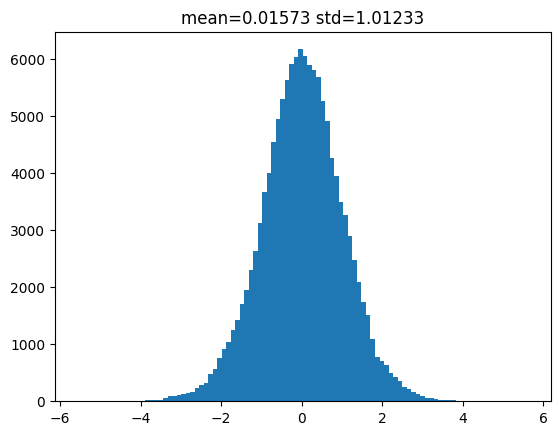

In [13]:
plt.hist(np.asarray(rews), bins=100);
plt.title(f"mean={rews.mean():0.05f} std={rews.std():0.05f}");

In [84]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
a = jax.random.ball(_rng, d=16, shape=(10000, ))
rng, _rng = split(rng)
b = jax.random.ball(_rng, d=16, shape=(10000, ))


In [85]:
a.shape, b.shape

((10000, 16), (10000, 16))

In [86]:
c = (a@b.T)
c.shape

(10000, 10000)

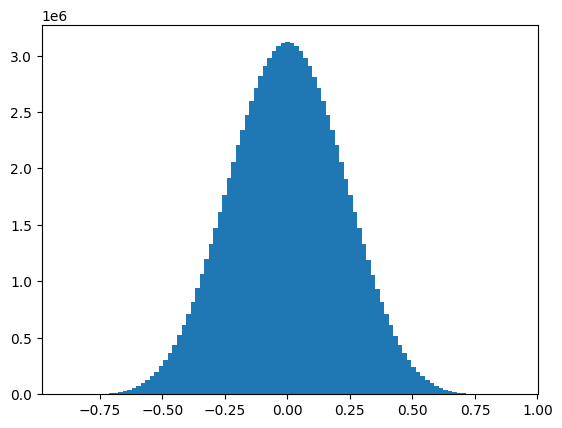

In [87]:
plt.hist(np.asarray(c.flatten()), bins=100);

In [88]:
np.asarray(c.flatten()).mean()

1.3673005e-05

In [89]:
np.asarray(c.flatten()).var()

0.0493934

In [5]:
import matplotlib
def temp_plot(x, label, c):
    mean, std = x.mean(axis=0), x.std(axis=0)
    err = std/np.sqrt(x.shape[0])
    plt.plot(mean, c=c, label=label)
    c = [c[0], c[1], c[2], .1]
    plt.fill_between(np.arange(len(mean)), mean-err, mean+err, color=c)

In [6]:
import matplotlib

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']



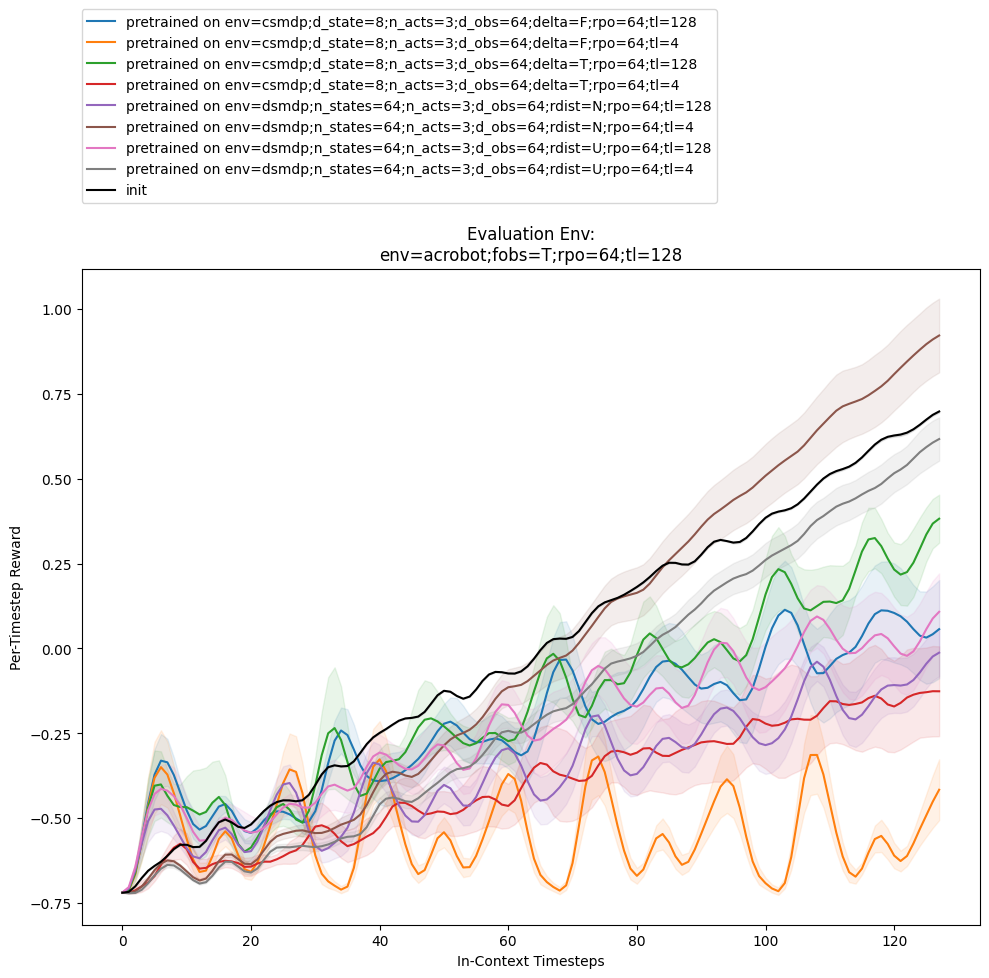

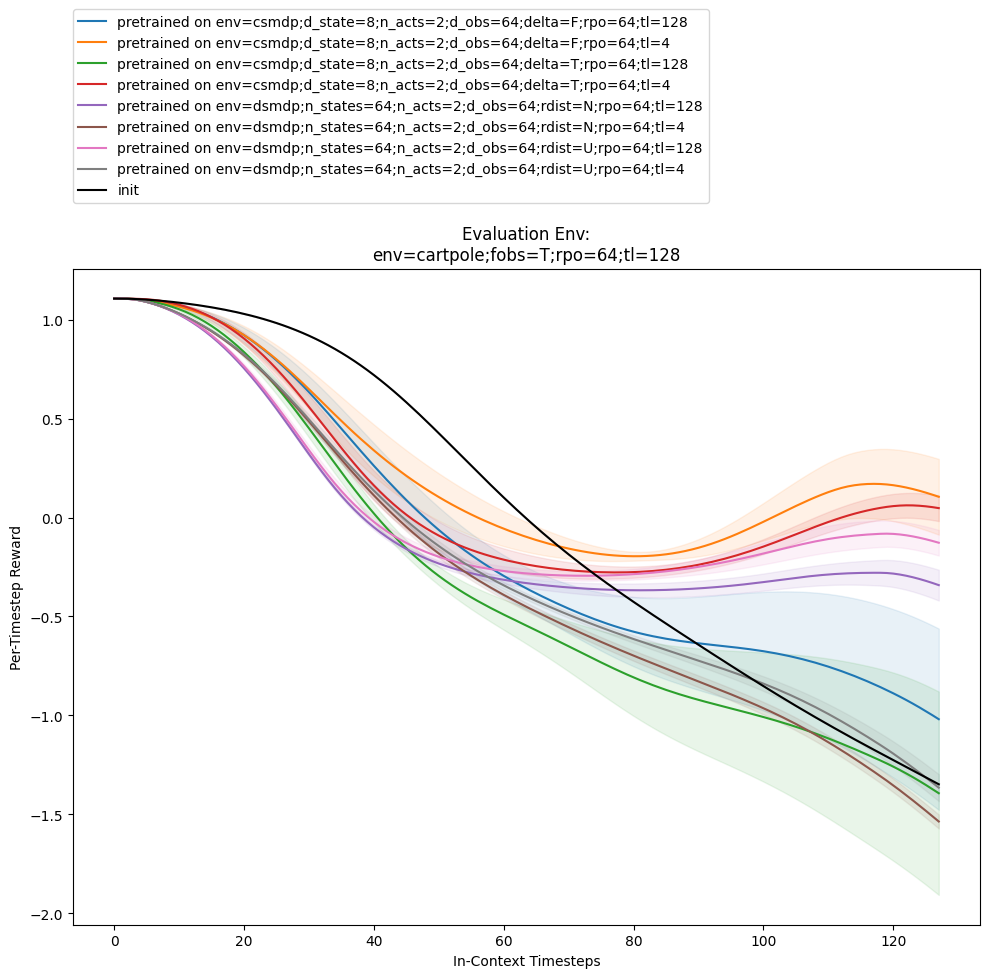

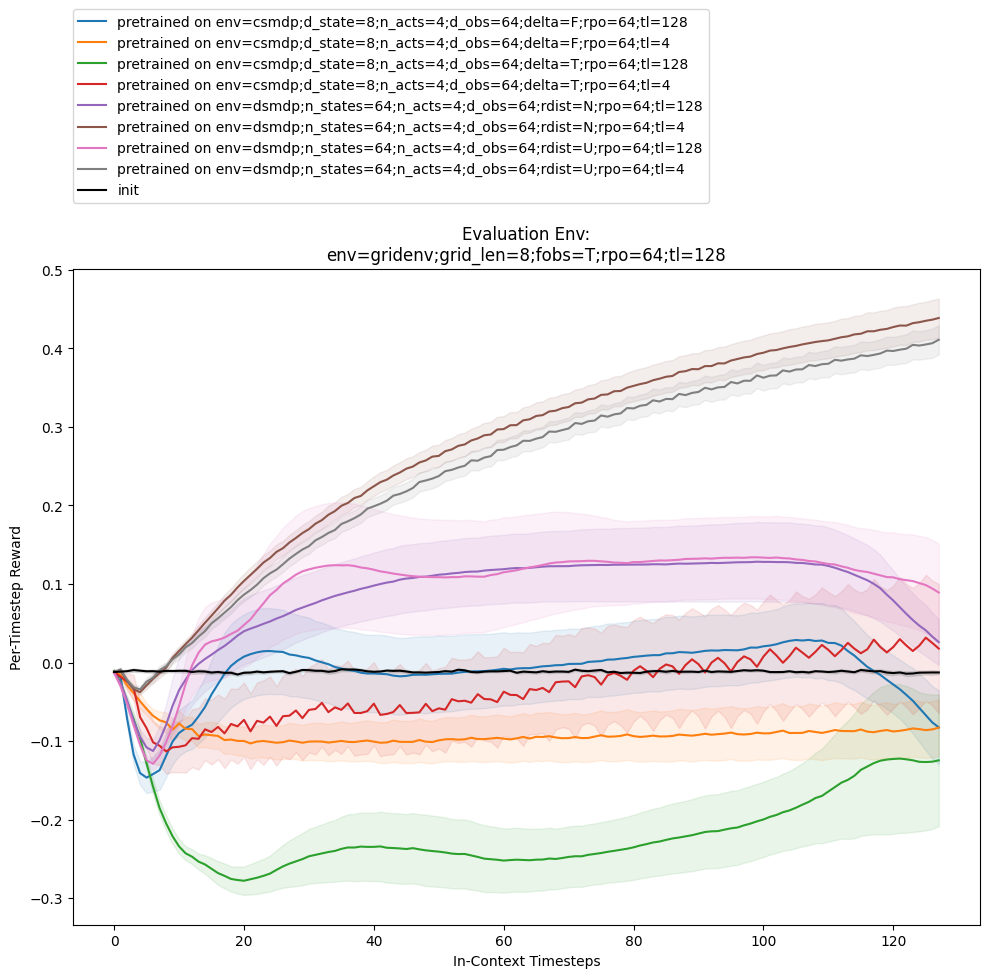

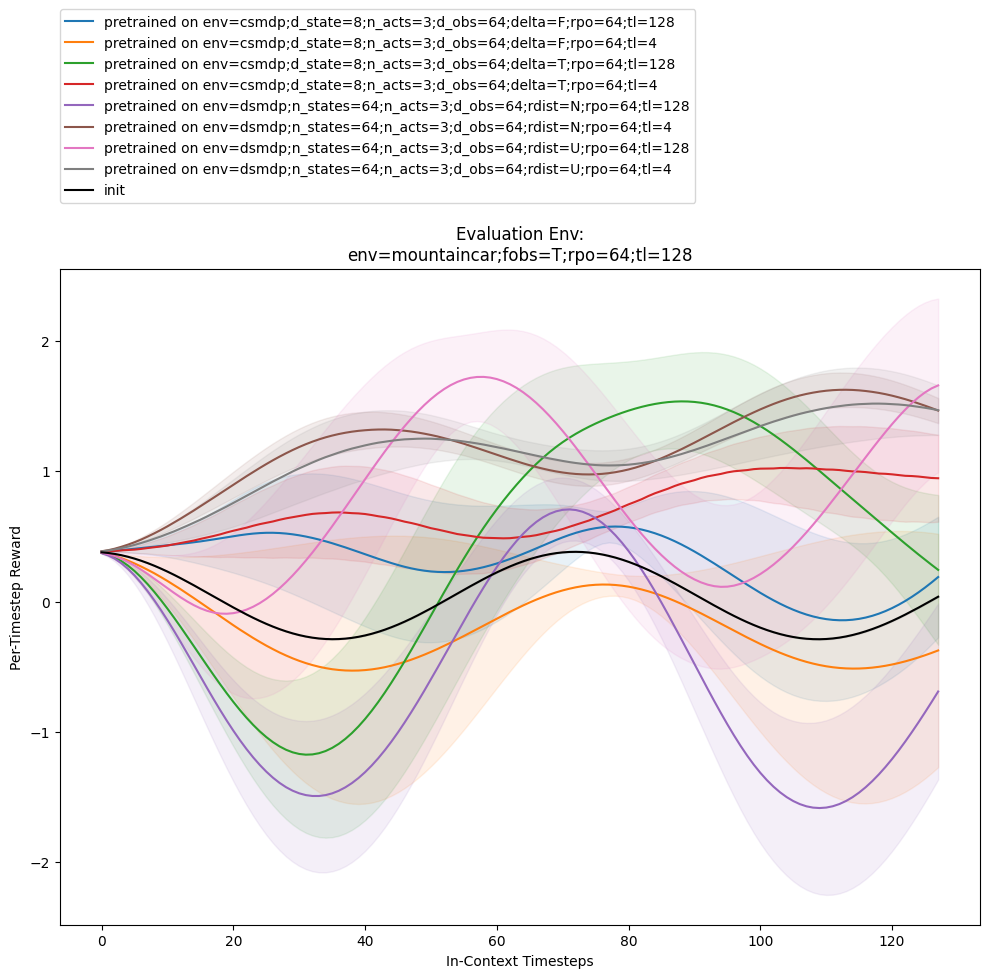

In [53]:
import glob
for env_trans in sorted(os.listdir('../data/transfer')):
    plt.figure(figsize=(10, 10))
    for i, env_pre in enumerate(sorted(os.listdir(f'../data/transfer/{env_trans}'))):
        with open(f'../data/transfer/{env_trans}/{env_pre}/rews_trained.pkl', 'rb') as f:
            rews_trained = np.asarray(pickle.load(f))
        temp_plot(rews_trained, label=f"pretrained on {env_pre}", c=matplotlib.colors.to_rgba(colors[i]))
    with open(f'../data/transfer/{env_trans}/{env_pre}/rews_init.pkl', 'rb') as f:
        rews_init = np.asarray(pickle.load(f))
    temp_plot(rews_init, label='init', c=matplotlib.colors.to_rgba('black'))
    plt.title(f'Evaluation Env:\n{env_trans}')
    plt.ylabel('Per-Timestep Reward')
    plt.xlabel('In-Context Timesteps')
    plt.legend(loc=(0., 1.1))
    plt.tight_layout()
    # plt.savefig(f'{args.save_dir}/plot_eval.png')

In [ ]:
TODO:
- show histogram of env rewards
- show animation of agent in discrete env


In [22]:
rews_init.shape

(8, 128)

In [24]:
rews_init[:, -1]

array([0.0384326 , 0.03832139, 0.03704006, 0.0368716 , 0.03499161,
       0.0305945 , 0.03770142, 0.04485235], dtype=float32)

In [10]:
env = MountainCar()


In [49]:
rng = jax.random.PRNGKey(0)
n = 1024

rng, _rng = split(rng)
obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(_rng, n), env.default_params)

rews = []
for t in range(128):
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (n,), 0, 3)
    rng, _rng = split(rng)
    obs, state, rew, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(_rng, n), state, act, env.default_params)
    rews.append(rew)
rews = np.asarray(jnp.stack(rews))


In [50]:
rews.shape

(128, 1024)

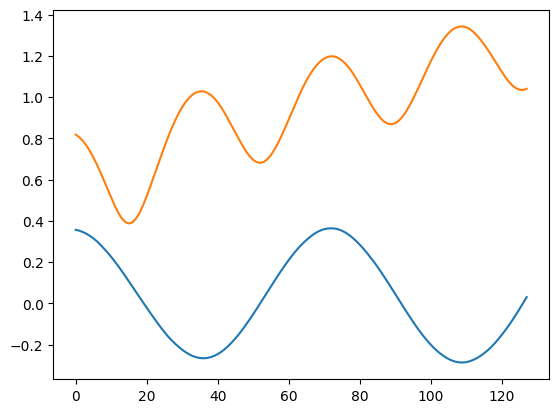

In [52]:
plt.plot(rews.mean(axis=-1))
plt.plot(rews.std(axis=-1))


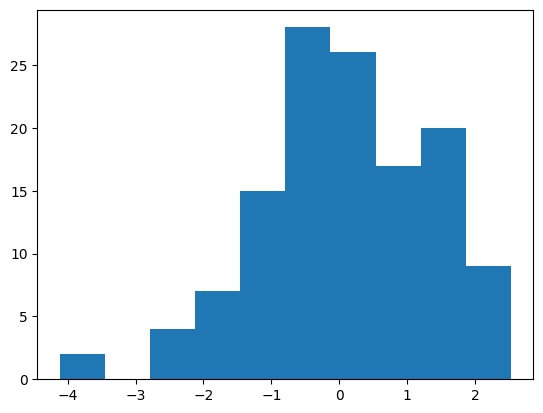

In [20]:
plt.hist(np.asarray(rew), bins=10);